# TRANSFER FUNCTIONS FOR CLOSED LOOP SYSTEMS

This notebook discusses how to create a transfer function for a closed loop.

# Preliminaries

In [1]:
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te
from IPython.display import Image

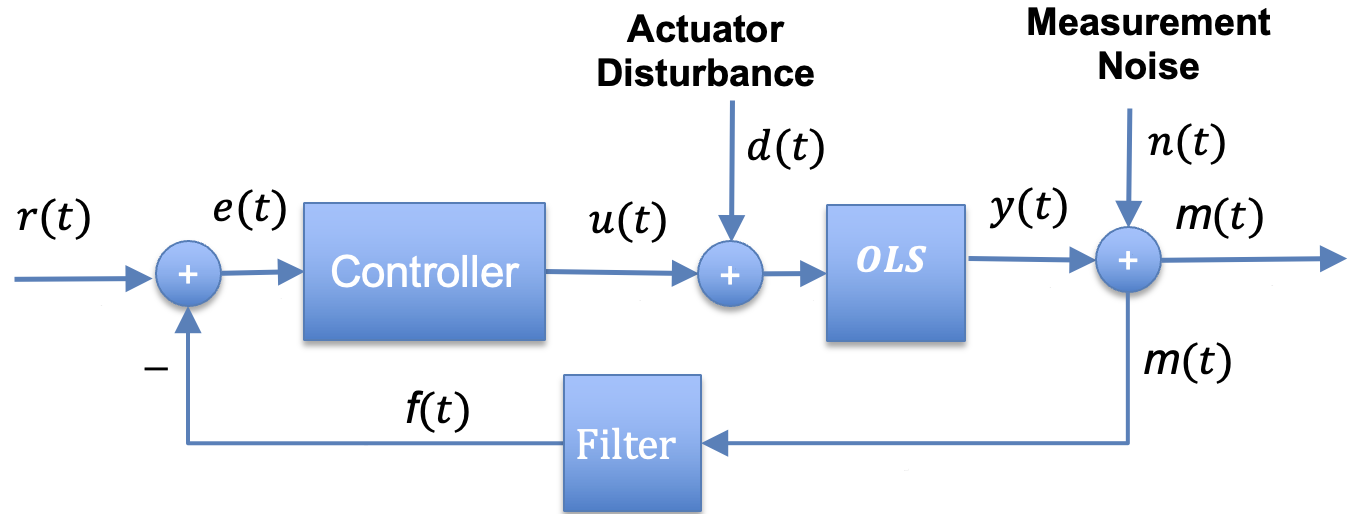

In [2]:
Image("closed_loop_system.png", width = 600, height = 300)

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Some other considerations:
1. Will the OLS always be within the operating region we designed for its input?
1. What are the maximum magnitudes of $d(t)$ and $n(t)$?
1. What trade-offs can we accepts?
    1. Achieved desired DC Gain but have oscillations? 
    1. Achieved desired DC Gain but have longer settling times?

## Note on notation
When we're talking about a system in isolation (e.g., a controller, a filter, an open loop system),
we use $u(t)$ for the input signal and $y(t)$ for the output signal.

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 1000)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

## ``plotSys``

In [5]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
times = T = np.linspace(0, 70, 500)
times, predictions, _ = plotSys(TEST_SYS, times, is_plot=False)
assert(len(times) == len(predictions[0]))
print("OK!")

OK!


# Models

## Linear

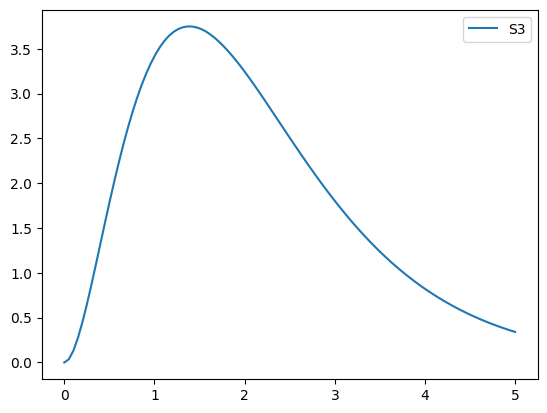

In [6]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

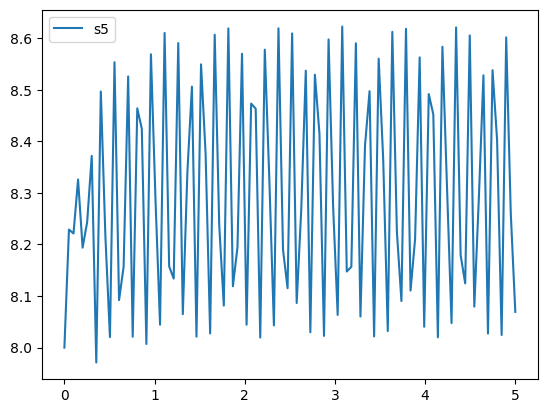

In [7]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

# Transfer Functions for PID Controller

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

## P Controller

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, for this system, the input $u(t)$ is the control error and the output $y(t)$ is the control input to the OLS.

**State and Output Equations**
1. There is no state, and so there is no state equation.
1. Output equation: $y(t) = k_P u(t)$.

**Laplace Transforms**
1. $Y(s) = k_P U(s)$

**Transfer Functions**
1. $G_P(s) = \frac{Y(s)}{U(s)} = k_P$

## I Controller

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

**State and Output Equations**
1. The state $x(t) = \int_0^{t} u(\tau) d \tau$.
1. Output equation: $y(t) = k_I x(t)$.

**Laplace Transforms**
1. $Y(s) = \frac{k_I}{s} U(s)$

**Transfer Functions**
1. $G_I(s) = \frac{Y(s)}{U(s)} = \frac{k_I}{s}$

## D Controller

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.

**State and Output Equations**
1. The state $x(t) = \frac{d u(t)}{d t}$.
1. Output equation: $y(t) = k_D x(t)$.

**Laplace Transforms**
1. $Y(s) = s k_D U(s)$

**Transfer Functions** 
1. $G_D(s) = \frac{Y(s)}{U(s)} = k_D s$

## PID Controller

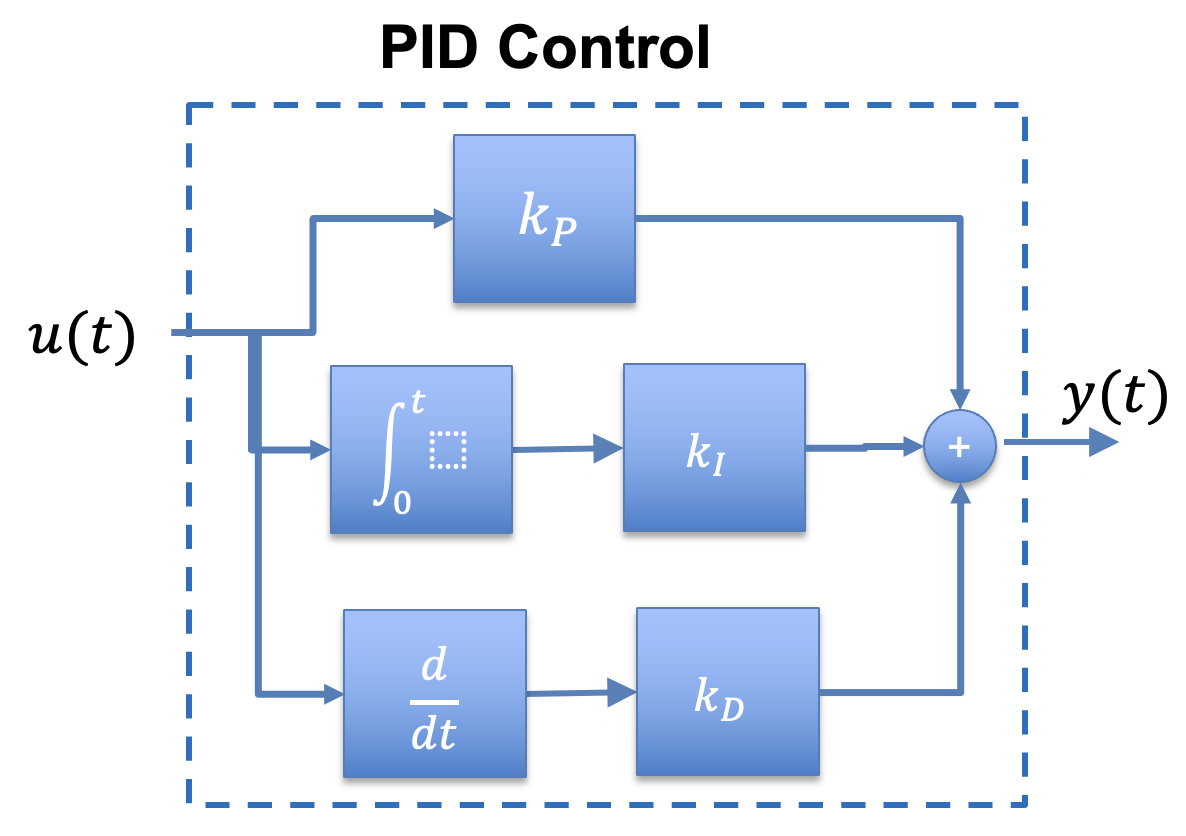

In [8]:
Image("pid_control.png", width = 300, height = 150)

PID control is the sum of the effects of the individual controllers.

$y_{PID}(t)$ is the sum of the signals output by the P, I, and D controllers.
So, $Y_{PID}(s)$ is the sum of these signals.
That is:
\begin{eqnarray}
Y_{PID} (s) & = & Y_P(s) + Y_I (s) + Y_D (s)\\
\end{eqnarray}

* The transfer function for the P controller is $G_P(s) = \frac{Y_P(s)}{U(s)}  = k_P$.
* The transfer function for  I controller is $G_I(s) = \frac{Y_I(s)}{U(s)} =  \frac{k_I}{s}$.
* The transfer function for  D controller is $G_D(s) = \frac{Y_D(s)}{U(s)} = k_D s$.

\begin{eqnarray}
G_{PID} (s) & = & \frac{Y_{PID}(s)}{U(s)} \\
& = & \frac{Y_P (s) + Y_I (s) + Y_D (s)}{U(s)} \\
& = & G_P (s) + G_I (s) + G_D (s) \\
& = & k_P + \frac{k_I}{s} + k_D s\\
\end{eqnarray}

**Question**
* What are the poles for a PI Controller?

# Transfer Function for Filter

Time domain behavior of the filter is $\frac{d y (t)}{d t} = k_F u(t) - k_F y(t)$.

Is there state?

Yes. State is the averaged output, $y(t)$. That is, $x(t) = y(t)$.

## State equations

$\frac{d y (t)}{d t} = k_F u(t) - k_F y(t)$

## Laplace transform of state equations

$s Y(s) = k_F U(s) - k_F Y(s)$

## Solve for transfer function

\begin{eqnarray}
s Y(s) & = & k_F U(s) - k_F Y(s) \\
Y(s) ( s + k_F) & = & k_F U(s) \\
Y(s) & = & \frac{k_F U(s)}{s + k_F} \\
G_F(s) & = & \frac{Y(s)}{U(s)}  \\
& =& \frac{k_F}{s + k_F}
\end{eqnarray}

**Questions**
1. What is the DC Gain?
1. Why must $k_F \geq 0$?
1. What is the effect of a large value of $k_F$? Explain in terms of the poles of $G_F(s)$.

# Transfer functions for the closed loop system

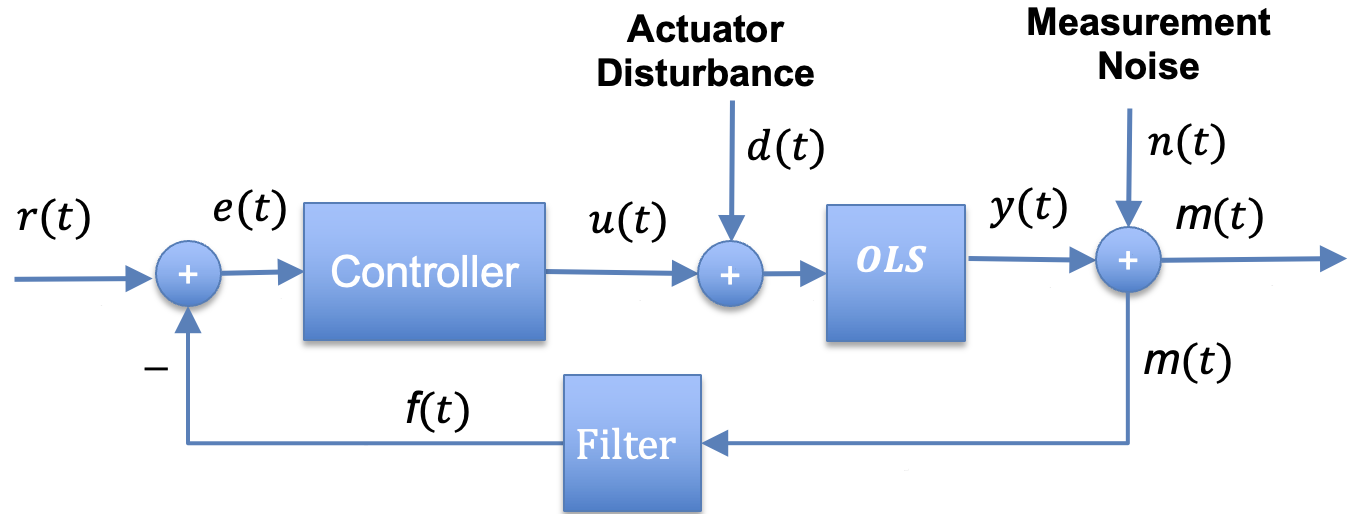

In [9]:
Image("closed_loop_system.png", width = 600, height = 300)

Define the following transfer functions:
* $G_C (s)$: controller
* $G_F (s)$: filter
* $G_O (s)$: open loop system

And the signals
* $R(s)$: reference input (set point)
* $D(S)$: disturbance
* $N(s)$: noise

Find the transfer function from $r(t)$ to $m(t)$.
That is, $G_{RM} = \frac{M(s)}{R(s)}$.

This transfer function assumes
that $n(t) = 0 = d(t)$.

## Write equations for relationships in the architecture

1. $M(s) = E(s) G_C (s) G_O(s)$
1. $E(s) = R(s) - M(s) G_F(s)$

## Solve for the transfer function

Substituting the second equation into the first:

\begin{eqnarray}
M(s) & = & E(s) G_C (s) G_O(s) \\
M(s)&  =& (R(s) - M(s) G_F(s) ) G_C (s) G_O(s) \\
M(s) ( 1 + G_C (s) G_O (s) G_F (s) )&  = & R(s) G_C (s) G_O(s) \\
G_{RM} (s) & = & \frac{M(s)}{R(s)} \\
& = & \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)} \\
\end{eqnarray}

**Questions**
1. What is the DC Gain of $G_{RM} (s)? Consider $G_C (0 ) \neq 0 \neq G_O (0)$.
   1. $G_F (0) = 1
   1. $G_F (0) \neq 1$
1. Repeat this question for the case where $G_C (s) = k_P + \frac{k_I}{s}$, integral control. 